In [27]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, f1_score
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
import joblib

**Memuat dataset dan memeriksa nilai yang hilang serta menghapus duplikat.**

In [3]:
# Memuat dataset
data = pd.read_csv('/content/ai4i2020.csv')

# Memeriksa nilai yang hilang
print("Missing values in each column:\n", data.isnull().sum())

# Menghapus duplikat
data.drop_duplicates(inplace=True)

Missing values in each column:
 UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


**Ekplorasi Data**

In [34]:
# Ringkasan Statistik
print("Summary statistics:\n", data.describe())

Summary statistics:
                 UDI  Air temperature [K]  Process temperature [K]  \
count   9822.000000          9822.000000              9822.000000   
mean    5001.799633           300.001161               310.002861   
std     2888.775929             1.998035                 1.482233   
min        1.000000           295.300000               305.700000   
25%     2498.250000           298.300000               308.800000   
50%     5003.500000           300.100000               310.100000   
75%     7504.750000           301.500000               311.100000   
max    10000.000000           304.500000               313.800000   

       Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  \
count             9822.000000  9822.000000      9822.000000      9822.000000   
mean              1526.222765    40.350713       107.912441         0.029831   
std                147.382767     9.448740        63.616929         0.170130   
min               1168.000000    16.7

In [35]:
# Distribusi Variabel Kategorikal
print("Value counts for 'Type':\n", data['Type'].value_counts())

Value counts for 'Type':
 Type
L    5894
M    2941
H     987
Name: count, dtype: int64


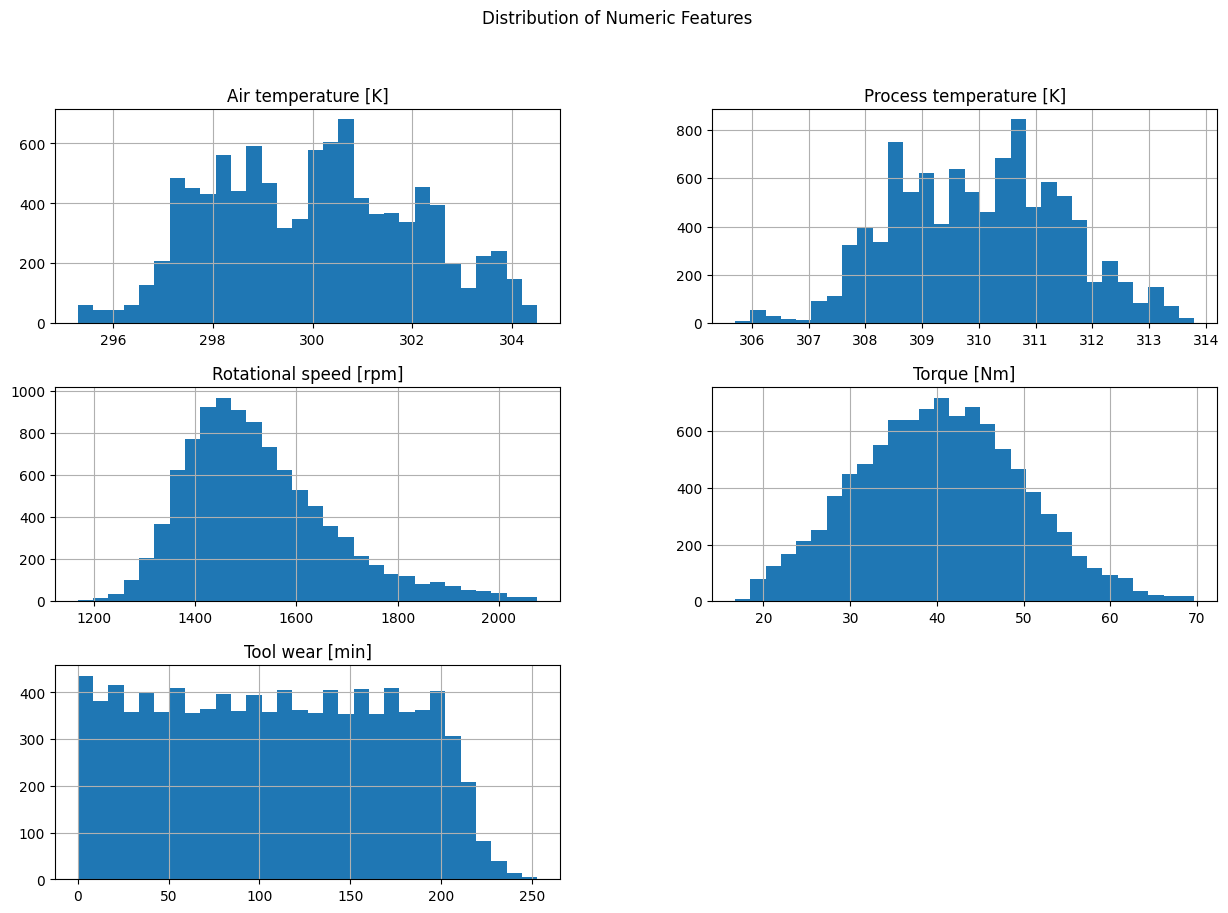

In [29]:
# Distribusi Variabel Numerik
numeric_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
data[numeric_features].hist(bins=30, figsize=(15, 10))
plt.suptitle("Distribution of Numeric Features")
plt.show()

In [30]:
# Distribusi Kegagalan Mesin
print("Machine failure distribution:\n", data['Machine failure'].value_counts())

Machine failure distribution:
 Machine failure
0    9529
1     293
Name: count, dtype: int64


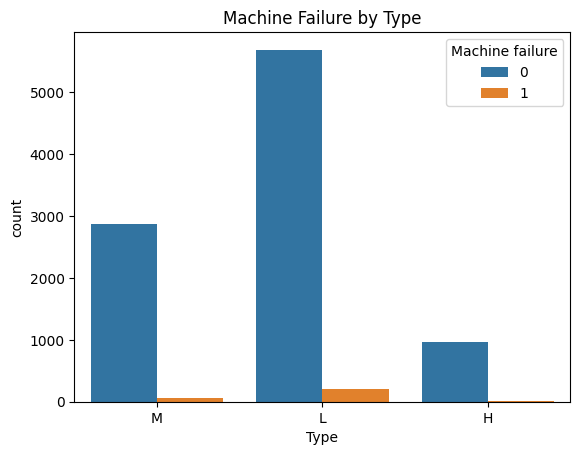

In [32]:
# Visualisasi Kegagalan Mesin berdasarkan Tipe
sns.countplot(x='Type', hue='Machine failure', data=data)
plt.title("Machine Failure by Type")
plt.show()

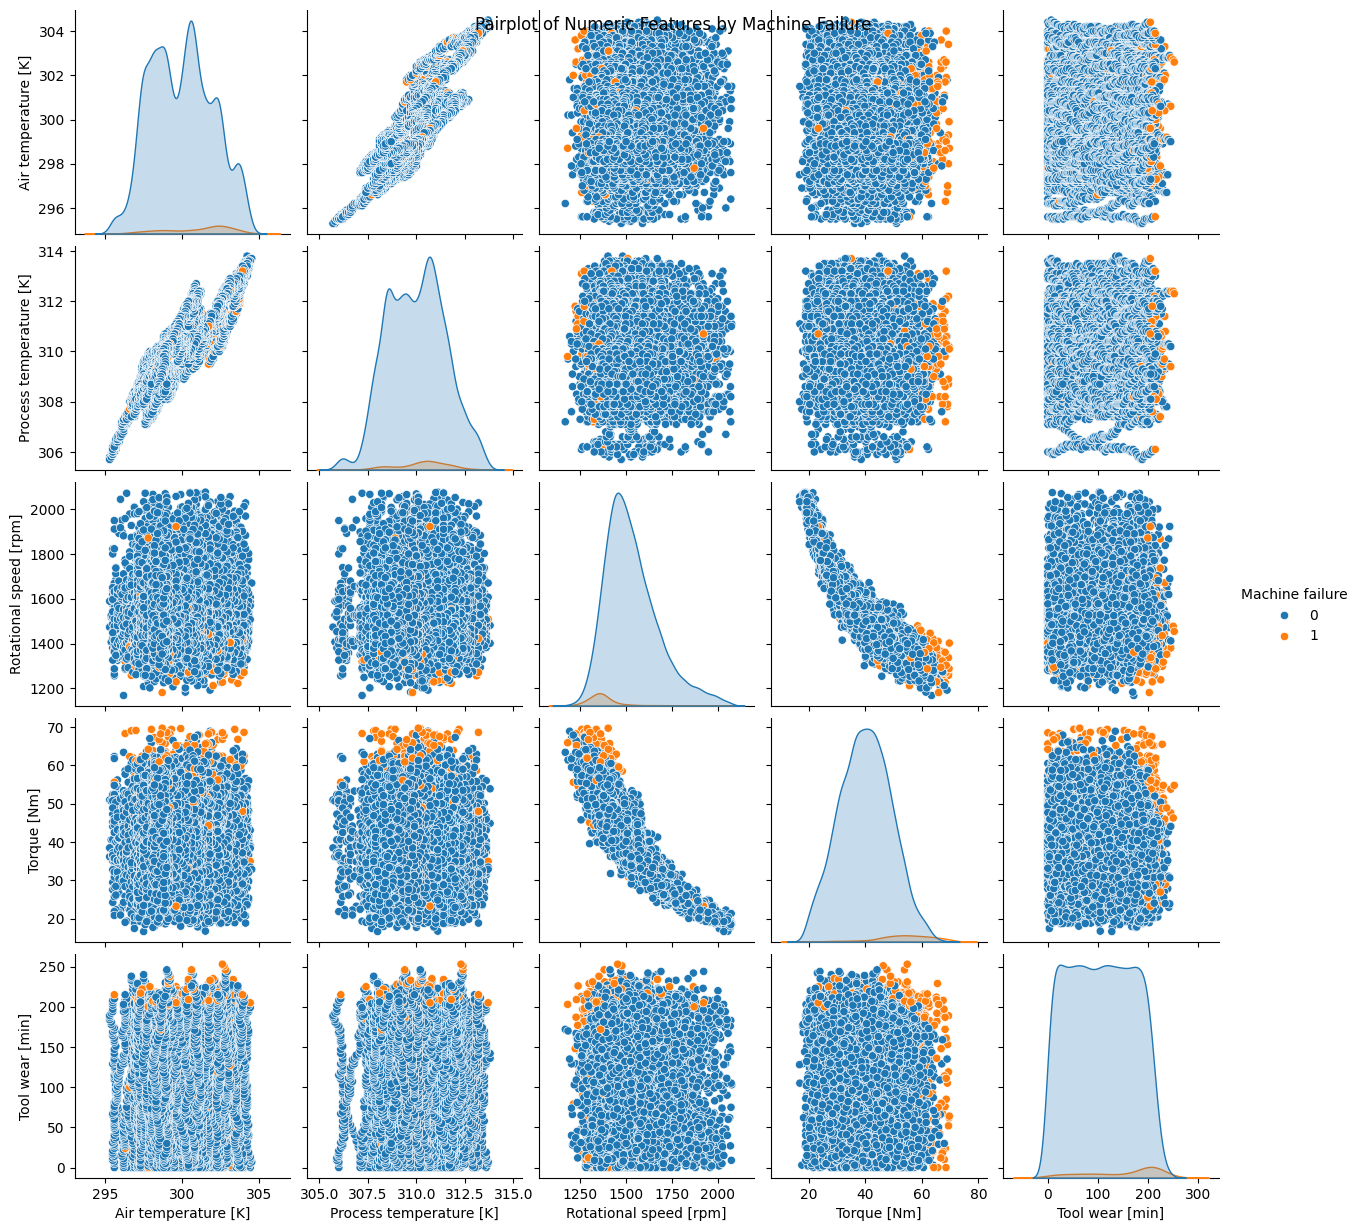

In [33]:
# Visualisasi hubungan antara fitur dan target
sns.pairplot(data, hue='Machine failure', vars=numeric_features)
plt.suptitle("Pairplot of Numeric Features by Machine Failure")
plt.show()

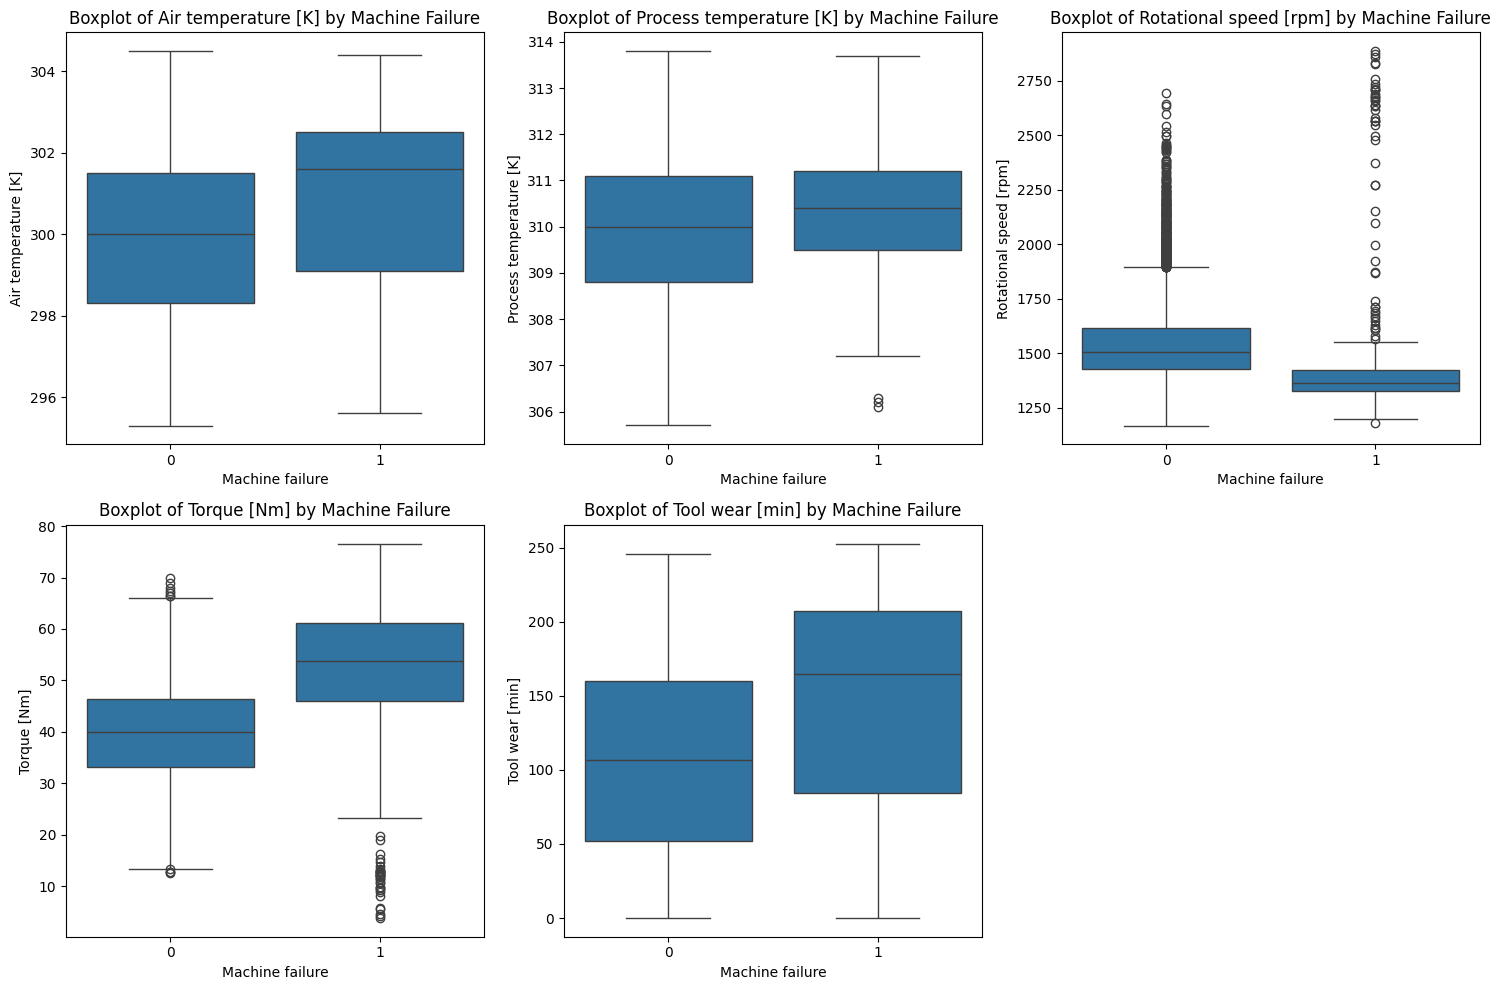

In [7]:
# Boxplot untuk mendeteksi outlier
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='Machine failure', y=feature, data=data)
    plt.title(f'Boxplot of {feature} by Machine Failure')
plt.tight_layout()
plt.show()

**Imputasi nilai yang hilang untuk kolom numerik dan kategorikal.**

In [10]:
# Imputasi nilai yang hilang secara terpisah untuk kolom numerik dan kategorikal
numeric_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
categorical_features = ['Type']

# Imputasi kolom numerik dengan strategi mean
numeric_imputer = SimpleImputer(strategy='mean')
data[numeric_features] = numeric_imputer.fit_transform(data[numeric_features])

# Imputasi kolom kategorikal dengan strategi yang paling sering muncul
categorical_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_features] = categorical_imputer.fit_transform(data[categorical_features])

**Deteksi dan penanganan outlier menggunakan metode Z-score.**

In [11]:
# Deteksi dan penanganan outlier (contoh menggunakan metode Z-score)
z_scores = np.abs(zscore(data[numeric_features]))
data = data[(z_scores < 3).all(axis=1)]

**Penyeimbangan data untuk menangani data yang tidak seimbang.**

In [12]:
# Penyeimbangan data untuk menangani data yang tidak seimbang
df_majority = data[data['Machine failure'] == 0]
df_minority = data[data['Machine failure'] == 1]

# Upsample kelas minoritas
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample dengan penggantian
                                 n_samples=len(df_majority),    # untuk mencocokkan kelas mayoritas
                                 random_state=123) # hasil yang dapat direproduksi

# Menggabungkan kelas mayoritas dengan kelas minoritas yang di-upsample
data_balanced = pd.concat([df_majority, df_minority_upsampled])

**Memisahkan fitur dan target serta mengatur pra-pemrosesan data.**

In [13]:
# Fitur dan target
X = data_balanced.drop(['UDI', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)
y = data_balanced['Machine failure']

# Pra-pemrosesan
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

**Membuat pipeline model dan melatih model.**

In [14]:
# Model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Membagi data menjadi set pelatihan, validasi, dan pengujian
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Melatih model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Air temperature [K]',
                                                   'Process temperature [K]',
                                                   'Rotational speed [rpm]',
                                                   'Torque [Nm]',
                                                   'Tool wear [min]']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Type'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

**Melakukan evaluasi pada set validasi dan pengujian.**

In [15]:
# Prediksi pada set validasi
y_val_pred = model.predict(X_val)

# Evaluasi pada set validasi
print("Validation Set Classification Report:\n", classification_report(y_val, y_val_pred))
print("Validation Set Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

Validation Set Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1868
           1       0.99      1.00      1.00      1944

    accuracy                           1.00      3812
   macro avg       1.00      1.00      1.00      3812
weighted avg       1.00      1.00      1.00      3812

Validation Set Confusion Matrix:
 [[1856   12]
 [   0 1944]]


Laporan Klasifikasi

1. Precision
- Kelas 0: 1.00
  
  Dari semua prediksi yang model katakan sebagai kelas 0, 100% benar.
- Kelas 1: 0.99

  Dari semua prediksi yang model katakan sebagai kelas 1, 99% benar.

2. Recall
- Kelas 0: 0.99

  Dari semua contoh sebenarnya yang merupakan kelas 0, 99% dikenali dengan benar oleh model.
- Kelas 1: 1.00

  Dari semua contoh sebenarnya yang merupakan kelas 1, 100% dikenali dengan benar oleh model.

3. F1-Score
- Kelas 0: 1.00
  
  Kombinasi dari precision dan recall untuk kelas 0 sangat baik.
- Kelas 1: 1.00

  Kombinasi dari precision dan recall untuk kelas 1 juga sangat baik.

4. Accuracy
-  Akurasi total: 1.00

  Model secara keseluruhan memiliki akurasi 100%, yang berarti semua prediksi yang dihasilkan model hampir sempurna.

5. Macro Avg
- Macro Avg Precision, Recall, F1-Score: 1.00

  Rata-rata dari metrik untuk kedua kelas menunjukkan bahwa model berkinerja sangat baik secara keseluruhan tanpa adanya ketidakseimbangan performa antar kelas.

6. Weighted Avg
- Weighted Avg Precision, Recall, F1-Score: 1.00

  Rata-rata tertimbang dari metrik juga menunjukkan performa tinggi, mempertimbangkan jumlah sampel di setiap kelas.

7. Matriks Kebingungan
-  True Positives (TP):

  Kelas 0: 1856

  Kelas 1: 1944

- False Positives (FP):

  Kelas 0: 0

  Kelas 1: 12

- False Negatives (FN):

  Kelas 0: 12

  Kelas 1: 0

- True Negatives (TN):

  Kelas 0: 1944

  Kelas 1: 1856


Ringkasan:

Model ini hampir sempurna dalam memprediksi kelas pada set validasi.

Precision, recall, dan F1-score sangat tinggi untuk kedua kelas, menunjukkan bahwa model ini sangat akurat dalam mengidentifikasi kedua kelas.
Matriks kebingungan menunjukkan sedikit kesalahan, dengan hanya 12 prediksi kelas 0 yang seharusnya kelas 1. Tidak ada kesalahan dalam mengenali kelas 1 sebagai kelas 0.
Secara keseluruhan, performa model sangat memuaskan dengan akurasi mendekati 100%, menandakan bahwa model ini sangat andal untuk tugas klasifikasi pada dataset yang diberikan.

In [16]:
# Prediksi pada set pengujian
y_test_pred = model.predict(X_test)

# Evaluasi pada set pengujian
print("Test Set Classification Report:\n", classification_report(y_test, y_test_pred))
print("Test Set Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Test Set Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1951
           1       0.99      1.00      1.00      1861

    accuracy                           1.00      3812
   macro avg       1.00      1.00      1.00      3812
weighted avg       1.00      1.00      1.00      3812

Test Set Confusion Matrix:
 [[1937   14]
 [   0 1861]]


Laporan Klasifikasi

1. Precision
- Kelas 0: 1.00

  Dari semua prediksi yang model katakan sebagai kelas 0, 100% benar.
- Kelas 1: 0.99

  Dari semua prediksi yang model katakan sebagai kelas 1, 99% benar.

2. Recall
- Kelas 0: 0.99

  Dari semua contoh sebenarnya yang merupakan kelas 0, 99% dikenali dengan benar oleh model.

- Kelas 1: 1.00

 Dari semua contoh sebenarnya yang merupakan kelas 1, 100% dikenali dengan benar oleh model.

3. F1-Score
- Kelas 0: 1.00

  Kombinasi dari precision dan recall untuk kelas 0 sangat baik.
- Kelas 1: 1.00

  Kombinasi dari precision dan recall untuk kelas 1 juga sangat baik.

4. Accuracy
- Akurasi total: 1.00

  Model secara keseluruhan memiliki akurasi 100%, yang berarti semua prediksi yang dihasilkan model hampir sempurna.

5. Macro Avg
- Macro Avg Precision, Recall, F1-Score: 1.00

  Rata-rata dari metrik untuk kedua kelas menunjukkan bahwa model berkinerja sangat baik secara keseluruhan tanpa adanya ketidakseimbangan performa antar kelas.

6. Weighted Avg
- Weighted Avg Precision, Recall, F1-Score: 1.00
  Rata-rata tertimbang dari metrik juga menunjukkan performa tinggi, mempertimbangkan jumlah sampel di setiap kelas.

7. Matriks Kebingungan
- True Positives (TP):

  Kelas 0: 1937

  Kelas 1: 1861

- False Positives (FP):

  Kelas 0: 0

  Kelas 1: 14

- False Negatives (FN):

  Kelas 0: 14

  Kelas 1: 0

- True Negatives (TN):

  Kelas 0: 1861

  Kelas 1: 1937

Ringkasan:

Model ini menunjukkan performa yang hampir sempurna pada set pengujian.

Precision, recall, dan F1-score sangat tinggi untuk kedua kelas, menunjukkan bahwa model ini sangat akurat dalam mengidentifikasi kedua kelas.
Matriks kebingungan menunjukkan sedikit kesalahan, dengan hanya 14 prediksi kelas 0 yang seharusnya kelas 1. Tidak ada kesalahan dalam mengenali kelas 1 sebagai kelas 0.
Secara keseluruhan, performa model sangat memuaskan dengan akurasi mendekati 100%, menandakan bahwa model ini sangat andal untuk tugas klasifikasi pada dataset pengujian yang diberikan.
Kesimpulannya, model ini bekerja dengan sangat baik baik pada set validasi maupun set pengujian, menunjukkan kemampuan generalisasi yang kuat dan kinerja klasifikasi yang sangat tinggi.

**Mengecek pentingnya fitur dan multikolinieritas.**

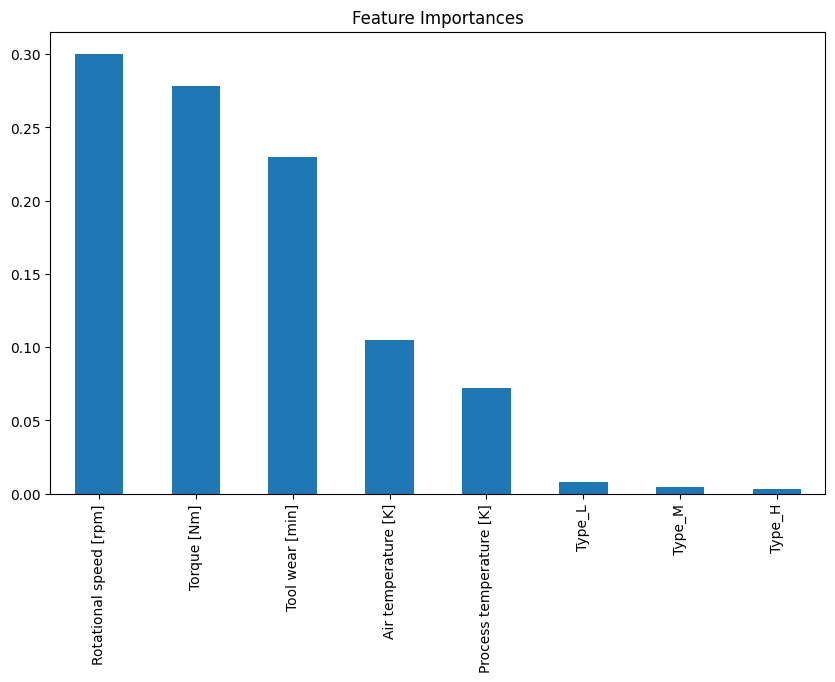

In [17]:
# Mengecek pentingnya fitur
rf = model.named_steps['classifier']
importances = rf.feature_importances_
features = numeric_features + list(model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out())
feature_importances = pd.Series(importances, index=features)

# Plot pentingnya fitur
plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importances')
plt.show()

**Memprediksi kegagalan mesin dengan data baru.**

In [18]:
# Data baru untuk prediksi
new_data = pd.DataFrame({
    'Air temperature [K]': [300],
    'Process temperature [K]': [310],
    'Rotational speed [rpm]': [1500],
    'Torque [Nm]': [40],
    'Tool wear [min]': [10],
    'Type': ['M']
})

# Prediksi kegagalan mesin
prediction = model.predict(new_data)
print(f'Predicted Machine Failure: {prediction[0]}')

Predicted Machine Failure: 0


1. Konteks Prediksi

- Machine Failure (Kegagalan Mesin):

  Kelas 0: Biasanya mewakili kondisi "tidak ada kegagalan mesin" atau "normal".
  
  Kelas 1: Biasanya mewakili kondisi "kegagalan mesin" atau "abnormal".


2. Penjelasan Prediksi

- Predicted Machine Failure:

  0 berarti model memprediksi bahwa mesin tidak mengalami kegagalan atau kondisi mesin adalah normal.

  Jika model mengklasifikasikan contoh tertentu sebagai kelas 0, maka model tersebut memutuskan bahwa mesin dalam kondisi baik dan tidak mengalami kegagalan.

3. Relevansi terhadap Klasifikasi

  Precision, Recall, F1-Score untuk Kelas 0:

  Precision dan recall yang sangat tinggi (mendekati atau sama dengan 1.00) menunjukkan bahwa prediksi "tidak ada kegagalan mesin" (kelas 0) sangat akurat.

4. Confusion Matrix:

  Menunjukkan bahwa dari 1951 contoh sebenarnya yang merupakan kelas 0, 1937 dikenali dengan benar sebagai kelas 0 (true positives) dan hanya 14 yang salah dikenali sebagai kelas 1 (false negatives).

5. Signifikansi dalam Praktik

- Keandalan Model:

  Model yang dapat dengan akurat memprediksi kondisi normal (tidak ada kegagalan) sangat penting untuk sistem yang memonitor kinerja mesin. Hal ini membantu dalam pemeliharaan prediktif dan mengurangi kemungkinan kegagalan mesin yang tidak terduga.

- Keputusan Pemeliharaan:

  Prediksi "0" mengindikasikan bahwa tidak diperlukan tindakan pemeliharaan segera atau pemeriksaan tambahan pada mesin, karena mesin diperkirakan dalam kondisi baik.

Secara keseluruhan, "Predicted Machine Failure: 0" berarti model memprediksi bahwa mesin akan beroperasi dengan normal tanpa mengalami kegagalan dalam periode yang diprediksi.

**Melakukan validasi silang dan tuning hyperparameter.**

In [19]:
# Validasi Silang
cv_scores = cross_val_score(model, X, y, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {cv_scores.mean()}')

# Tuning Hyperparameter dengan GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_features': ['sqrt', 'log2'],  # diupdate dari 'auto' ke 'sqrt'
    'classifier__max_depth': [None, 10, 20, 30]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')

Cross-validation scores: [0.99265477 0.99055614 0.93100735 0.99370244 0.99868801]
Mean cross-validation score: 0.9813217413666685
Best parameters: {'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__n_estimators': 300}


1. Cross-validation scores:

  Nilai-nilai ini menunjukkan kinerja model pada setiap lipatan (fold) dalam proses cross-validation. Dalam hal ini, ada 5 lipatan dan masing-masing memberikan skor sebagai berikut:

- Lipatan 1: 0.99265477
- Lipatan 2: 0.99055614
- Lipatan 3: 0.93100735
- Lipatan 4: 0.99370244
- Lipatan 5: 0.99868801

Skor ini menunjukkan bahwa model memiliki kinerja yang sangat baik di hampir semua lipatan, kecuali pada lipatan 3 yang memiliki skor lebih rendah (0.93100735). Hal ini menunjukkan ada sedikit variabilitas dalam kinerja model pada berbagai subset data.

2. Mean cross-validation score:

  Rata-rata skor cross-validation adalah 0.9813217413666685. Ini menunjukkan bahwa secara keseluruhan, model memiliki kinerja yang sangat baik pada data yang berbeda yang digunakan dalam cross-validation.

**Menyimpan dan memuat model yang telah dilatih.**

In [20]:
# Menyimpan model
joblib.dump(model, 'random_forest_model.pkl')

# Memuat model
loaded_model = joblib.load('random_forest_model.pkl')

**Melakukan evaluasi tambahan data.**

In [23]:
# Evaluasi Lengkap
roc_auc = roc_auc_score(y_test, y_test_pred)
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f'ROC-AUC: {roc_auc}')
print(f'F1 Score: {f1}')

ROC-AUC: 0.9964120963608406
F1 Score: 0.996252676659529


1. ROC-AUC (Receiver Operating Characteristic - Area Under the Curve):

- Nilai: 0.9964120963608406

  ROC-AUC mengukur seberapa baik model dapat memisahkan antara kelas positif dan negatif.

  Nilai ROC-AUC yang mendekati 1.0 menunjukkan bahwa model memiliki kemampuan yang sangat baik dalam membedakan antara kelas positif dan negatif.

  Lebih spesifik, nilai ROC-AUC yang tinggi (di atas 0.5) menunjukkan bahwa model memiliki tingkat true positive yang tinggi dan tingkat false positive yang rendah, yang sangat diinginkan dalam banyak kasus.

2. F1 Score:

- Nilai: 0.996252676659529

  F1 Score adalah ukuran gabungan dari precision dan recall, yang memberikan gambaran tentang seberapa baik model dapat mengidentifikasi kelas positif tanpa mengabaikan kelas negatif.

  F1 Score yang mendekati 1.0 menunjukkan bahwa model memiliki presisi (precision) dan recall yang sangat tinggi secara bersamaan.

  Nilai F1 Score yang tinggi menunjukkan bahwa model memiliki keseimbangan yang baik antara precision dan recall, yang penting terutama jika kelas positif dan negatif tidak seimbang dalam dataset.

Kesimpulan

Nilai ROC-AUC yang tinggi (0.9964) menunjukkan bahwa model memiliki performa yang sangat baik dalam memisahkan antara kelas positif dan negatif.

F1 Score yang tinggi (0.9963) menunjukkan bahwa model memiliki presisi yang tinggi dalam mengklasifikasikan kelas positif dan recall yang tinggi dalam mengidentifikasi sebagian besar dari kelas positif yang sebenarnya.

Secara keseluruhan, kedua metrik ini menunjukkan bahwa model klasifikasi yang dievaluasi memiliki performa yang sangat tinggi dan dapat diandalkan untuk tugas klasifikasi pada dataset yang digunakan.

**Menggunakan skenario data baru untuk pengujian.**

In [ ]:
# Pengujian dengan Skenario Data Baru
new_data_scenarios = pd.DataFrame({
    'Air temperature [K]': [290, 300, 310],
    'Process temperature [K]': [305, 310, 315],
    'Rotational speed [rpm]': [1400, 1500, 1600],
    'Torque [Nm]': [35, 40, 45],
    'Tool wear [min]': [5, 10, 15],
    'Type': ['M', 'L', 'H']
})

predictions = loaded_model.predict(new_data_scenarios)
print(f'Predictions for new scenarios: {predictions}')

Predictions for new scenarios: [0 0 0]


Prediksi untuk skenario data baru adalah [0, 0, 0]. Artinya:

1. Skenario pertama (indeks 0):

  Model memprediksi bahwa mesin tidak akan mengalami kegagalan.
2. Skenario kedua (indeks 1):

  Model juga memprediksi bahwa mesin tidak akan mengalami kegagalan.
3. Skenario ketiga (indeks 2):

  Begitu juga, model memprediksi bahwa mesin tidak akan mengalami kegagalan.

Dengan kata lain, berdasarkan fitur-fitur yang diberikan dalam skenario baru, model memprediksi bahwa dalam semua kasus, mesin tidak akan mengalami kegagalan (kelas 0).